# Data cleaning and variable selection

In [1]:
import numpy as np
import pandas as pd
from sklearn.cross_validation import StratifiedKFold
from sklearn.grid_search import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import Lasso
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn import metrics

In [3]:
#Chargement du fichier dataProjet.csv dans le dataframe df, n'oubliez pas de modifier le chemin 
#pour tenir compte de l'endroit ou se trouve votre fichier
df = pd.read_csv("train.csv")

In [4]:
# happy customers have TARGET==0, unhappy custormers have TARGET==1
# A little less then 4% are unhappy => unbalanced dataset
data = pd.DataFrame(df.TARGET.value_counts())
data['Percentage'] = 100*data['TARGET']/df.shape[0]
data

,TARGET,Percentage
0,73012,96.043147
1,3008,3.956853


In [5]:
df.head(10)

,ID,var3,var15,imp_ent_var16_ult1,imp_op_var39_comer_ult1,imp_op_var39_comer_ult3,imp_op_var40_comer_ult1,imp_op_var40_comer_ult3,imp_op_var40_efect_ult1,imp_op_var40_efect_ult3,...,saldo_medio_var33_hace2,saldo_medio_var33_hace3,saldo_medio_var33_ult1,saldo_medio_var33_ult3,saldo_medio_var44_hace2,saldo_medio_var44_hace3,saldo_medio_var44_ult1,saldo_medio_var44_ult3,var38,TARGET
0,1,2,23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,39205.170000,0
1,3,2,34,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,49278.030000,0
2,4,2,23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,67333.770000,0
3,8,2,37,0.0,195.0,195.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,64007.970000,0
4,10,2,39,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,117310.979016,0
5,13,2,23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,87975.750000,0
6,14,2,27,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,94956.660000,0
7,18,2,26,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,251638.950000,0
8,20,2,45,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,101962.020000,0
9,23,2,25,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,356463.060000,0


<h3><span style="color: #3366ff;">Nettoyage des données</span></h3>

In [6]:
def Liste_Att():
    Liste=[]
    for x in df.columns.values:
        Liste.append(x)
    return Liste

In [7]:
Liste = Liste_Att()
#Identifier les colonnes inutiles (dont l'écart type est null)

Bruit=[]
for i in xrange(len(Liste)):
    #pour chaque colonne "df[x]"
    if np.std(df[Liste[i]]) == 0.0:
        #on recupère la liste des noms des colonnes "df.columns.values" et on la parcours
        Bruit.append(Liste[i])
print 'Le nombre des colonnes inutiles est : ',len(Bruit)

#Les colonnes dont std = 0 , on va donc les supprimer parcequ'il est 
#n'apportera pas grand chose pour l'apprentissage (c'est que du bruit)

for i in xrange(len(Bruit)):
    df.drop(Bruit[i], axis=1, inplace=True)

#Colonne ID est non utile pour faire l'apprentissage, donc on le supprime
df.drop('ID', axis=1, inplace=True)
    
Liste = Liste_Att()

Le nombre des colonnes inutiles est :  34


In [8]:
#Identifier les colonnes dont les valeurs sont identiques
Liste = Liste_Att()

identical = []
dupliquer = []
for i in xrange(len(Liste)):
    temp = []
    if i not in identical:
        a = np.array(df[Liste[i]])
        for j in xrange(len(Liste)):
            if  i!=j:
                b = np.array(df[Liste[j]])
                if np.array_equal(a,b):
                    temp.append(j)
                    identical.append(j)
    dupliquer.append(temp)
    
print 'Le nombre des colunnes identiques est : ',len(identical)

#Delete les colonnes dont les valeurs sont identiques
for i in xrange(len(identical)):
    df.drop([Liste[identical[i]]], axis=1, inplace=True)

#Actualiser la liste des colonnes
Liste = Liste_Att()

Le nombre des colunnes identiques est :  29


In [9]:
def resemblance(column1 , column2):
    a = np.array(df[column1])
    b = np.array(df[column2])
    return ((a==b).sum() * 1.0)/len(a)

In [10]:
#Actualiser la liste des colonnes
Liste = Liste_Att()
Liste=Liste[:-1]
seuil=0.99

resemble=[]
jump = []
for i in xrange(len(Liste)):
    if i not in jump:
        for j in xrange(len(Liste)):
            if i!=j and resemblance(Liste[i], Liste[j]) >= seuil:
                if j not in jump:
                    #resemble.append(Liste[j])
                    jump.append(j)
    else:
        tempo=[]
        for j in xrange(len(Liste)):
            if i!=j and resemblance(Liste[i], Liste[j]) >= seuil:
                if j not in jump:
                    tempo.append(j)
        if len(tempo) >= 2:
            #resemble.extend(tempo[:-1])
            jump.extend(tempo[:-1])
print "Nombre des colonnes qui se ressemblent : ", len(jump)

def double(jump):
    proc = []
    doublons = []
    for r in jump:
         if r not in proc:
             proc.append(r)
         else:
             doublons.append(r)
    return doublons

#Delete les colonnes dont les valeurs se ressemblent
if len(double(jump))==0:
    for i in xrange(len(jump)):
        df.drop([Liste[jump[i]]], axis=1, inplace=True)
        resemble.append(Liste[jump[i]])
    print "..... droped"
else:
    print "ERROR..."

#Actualiser la liste des colonnes
Liste = Liste_Att()

Nombre des colonnes qui se ressemblent :  202
..... droped


In [11]:
print " Le nombre des variables restante est: ",len(Liste)

 Le nombre des variables restante est:  105


,attribute pair,correlation
12,"(ind_var8_0, num_var8_0)",0.999793
3,"(ind_var1_0, num_var1_0)",0.998849
10,"(num_med_var45_ult3, num_var45_ult3)",0.997806
4,"(ind_var24_0, num_var24_0)",0.997448
7,"(ind_var5, num_var5)",0.993709
5,"(saldo_medio_var12_ult1, saldo_var12)",0.986397
15,"(saldo_medio_var12_ult1, saldo_medio_var12_ult3)",0.985940
6,"(num_var35, num_var4)",0.983125
0,"(saldo_medio_var13_corto_ult3, saldo_var13_corto)",0.980455
9,"(saldo_var12, saldo_var42)",0.978415


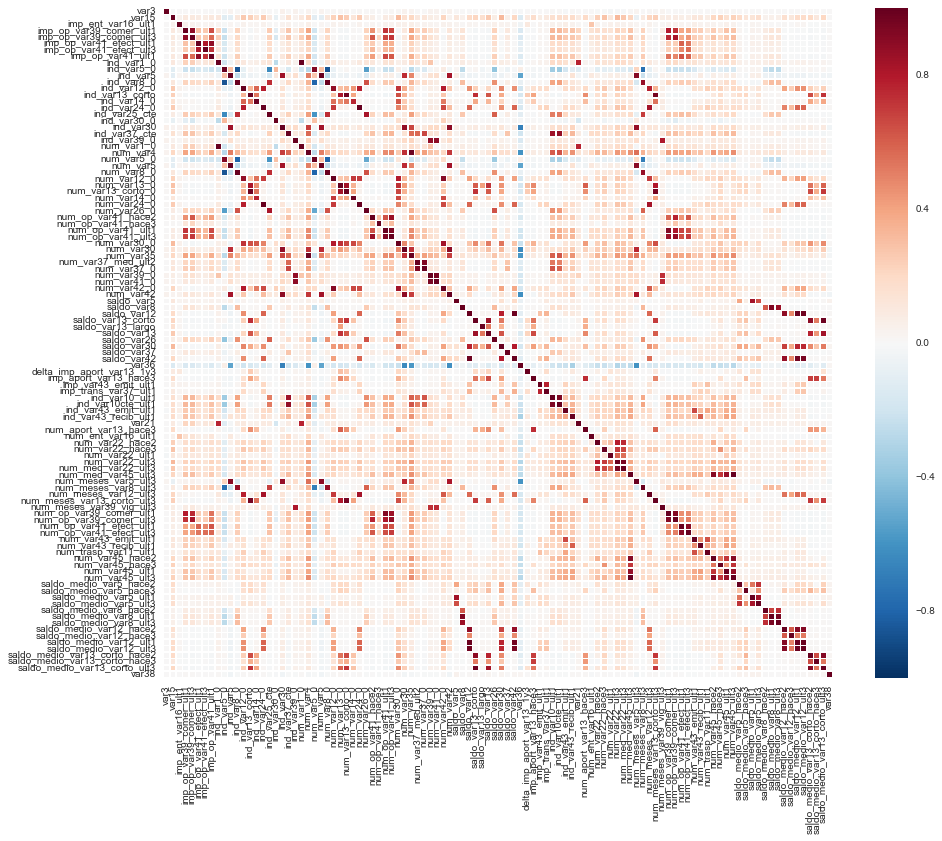

In [12]:
import seaborn as sns
cor_mat = df.iloc[:,:-1].corr()

f, ax = plt.subplots(figsize=(15, 12))
# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(cor_mat,linewidths=.5, ax=ax);

# only important correlations and not auto-correlations
threshold = 0.95
important_corrs = (cor_mat[abs(cor_mat) > threshold][cor_mat != 1.0]) \
    .unstack().dropna().to_dict()
unique_important_corrs = pd.DataFrame(
    list(set([(tuple(sorted(key)), important_corrs[key]) \
    for key in important_corrs])), columns=['attribute pair', 'correlation'])
# sorted by absolute value
unique_important_corrs = unique_important_corrs.ix[
    abs(unique_important_corrs['correlation']).argsort()[::-1]]
unique_important_corrs

In [13]:
import re
for x in df.columns.values:
    for m in xrange(len(df)):
        r=df[x][m]
        if re.search("^-9{3,14}$",str(r)):
            print x,r

var3 -999999
var3 -999999
var3 -999999
var3 -999999
var3 -999999
var3 -999999
var3 -999999
var3 -999999
var3 -999999
var3 -999999
var3 -999999
var3 -999999
var3 -999999
var3 -999999
var3 -999999
var3 -999999
var3 -999999
var3 -999999
var3 -999999
var3 -999999
var3 -999999
var3 -999999
var3 -999999
var3 -999999
var3 -999999
var3 -999999
var3 -999999
var3 -999999
var3 -999999
var3 -999999
var3 -999999
var3 -999999
var3 -999999
var3 -999999
var3 -999999
var3 -999999
var3 -999999
var3 -999999
var3 -999999
var3 -999999
var3 -999999
var3 -999999
var3 -999999
var3 -999999
var3 -999999
var3 -999999
var3 -999999
var3 -999999
var3 -999999
var3 -999999
var3 -999999
var3 -999999
var3 -999999
var3 -999999
var3 -999999
var3 -999999
var3 -999999
var3 -999999
var3 -999999
var3 -999999
var3 -999999
var3 -999999
var3 -999999
var3 -999999
var3 -999999
var3 -999999
var3 -999999
var3 -999999
var3 -999999
var3 -999999
var3 -999999
var3 -999999
var3 -999999
var3 -999999
var3 -999999
var3 -999999
var3 -999999

In [14]:
for x in df.columns.values:
    if df.loc[df[x]<0].shape[0] != 0:
        print x, df.loc[df[x]<0].shape[0]

var3 116
saldo_var5 108
saldo_var8 19
saldo_var30 120
saldo_var42 122
delta_imp_aport_var13_1y3 1690
saldo_medio_var5_hace2 26
saldo_medio_var5_hace3 4
saldo_medio_var5_ult1 51
saldo_medio_var5_ult3 24
saldo_medio_var8_hace2 2
saldo_medio_var8_ult1 12
saldo_medio_var8_ult3 7


In [15]:
# 10 premières valeurs les plus communes
df.var3.value_counts()[:10]

 2         74165
 8           138
-999999      116
 9           110
 3           108
 1           105
 13           98
 7            97
 4            86
 12           85
Name: var3, dtype: int64

In [16]:
# 116 valeurs dans la colonne var3 sont-999999
# on soupçonne que var3 est la nationalité du client
# - 999999 signifierait que la nationalité du client est inconnue

print df.loc[df.var3==-999999].shape

# Remplacez -999999 dans la colonne var3 avec la valeur la plus commune 2

df = df.replace(-999999,2)
print df.loc[df.var3==-999999].shape

(116, 105)
(0, 105)


In [17]:
print Liste

['var3', 'var15', 'imp_ent_var16_ult1', 'imp_op_var39_comer_ult1', 'imp_op_var39_comer_ult3', 'imp_op_var41_efect_ult1', 'imp_op_var41_efect_ult3', 'imp_op_var41_ult1', 'ind_var1_0', 'ind_var5_0', 'ind_var5', 'ind_var8_0', 'ind_var12_0', 'ind_var13_corto', 'ind_var14_0', 'ind_var24_0', 'ind_var25_cte', 'ind_var30_0', 'ind_var30', 'ind_var37_cte', 'ind_var39_0', 'num_var1_0', 'num_var4', 'num_var5_0', 'num_var5', 'num_var8_0', 'num_var12_0', 'num_var13_0', 'num_var13_corto_0', 'num_var14_0', 'num_var24_0', 'num_var26_0', 'num_op_var41_hace2', 'num_op_var41_hace3', 'num_op_var41_ult1', 'num_op_var41_ult3', 'num_var30_0', 'num_var30', 'num_var35', 'num_var37_med_ult2', 'num_var37_0', 'num_var39_0', 'num_var41_0', 'num_var42_0', 'num_var42', 'saldo_var5', 'saldo_var8', 'saldo_var12', 'saldo_var13_corto', 'saldo_var13_largo', 'saldo_var13', 'saldo_var26', 'saldo_var30', 'saldo_var37', 'saldo_var42', 'var36', 'delta_imp_aport_var13_1y3', 'imp_aport_var13_hace3', 'imp_var43_emit_ult1', 'imp_t

In [18]:
df.to_csv("DataClean.csv")

In [19]:
#Y, X, X_train, X_test, Y_train, Y_test = ""

def splitData(df):
    Y = df.TARGET
    X = df.drop(['TARGET'], axis=1)

    # diviser X et Y en training and testing
    from sklearn.cross_validation import train_test_split
    return  train_test_split(X, Y, test_size=0.2,random_state=1)

In [20]:
X_train, X_test, Y_train, Y_test = splitData(df)

In [27]:
df1 = pd.DataFrame(Y_train.value_counts())
df1['Percentage'] = 100*df1['TARGET']/Y_train.shape[0]
print 'train \n\n',df1

df2 = pd.DataFrame(Y_test.value_counts())
df2['Percentage'] = 100*df2['TARGET']/Y_test.shape[0]
print 'test \n\n',df2

train 

   TARGET  Percentage
0   58411   96.045449
1    2405    3.954551
test 

   TARGET  Percentage
0   14601   96.033938
1     603    3.966062


In [28]:
X=X_train
Y=Y_train

XValid=X_test
YValid=Y_test

<h3><span style="color: #3366ff;">Les arbres de décision</span></h3>

In [29]:
#CHOIX DU MODELE A UTILISER
#Les arbres de décision


clf = DecisionTreeClassifier(random_state=1)
params = {'max_depth':[1,3,4,5,6,7,9],
          'min_samples_leaf' : [1,3,4,5,6,7,9]} #pour le gridSearch    
metric = 'roc_auc'


In [30]:
#fonction d'apprentissage avec cross validation et gridsearch sur le premier dataset
def performance(X,Y):
    kf = StratifiedKFold(Y, n_folds=3, random_state=1)    
    gs = GridSearchCV(clf, params, scoring=metric, cv=kf)
    gs.fit(X,Y)
    return gs

#fonction de prédiction sur le dataset de validation
def validation(clf1, Xv, Yv):
    preds = clf1.predict_proba(Xv)[:,1]
    return roc_auc_score(Yv, preds)

gs = performance(X,Y)
print "Resultat d'apprentissage : ",gs.best_score_, gs.best_params_

print "Resultat de validation : ",validation(gs.best_estimator_, XValid, YValid)

Resultat d'apprentissage :  0.813552684817 {'max_depth': 6, 'min_samples_leaf': 4}
Resultat de validation :  0.81579830001


<h5 style="color:blue;">Avec 105 Variables </h5>
<hr/>
<b>n_folds=3</b><br/>
Resultat d'apprentissage :  0.816272752522 {'max_depth': 6, 'min_samples_leaf': 9}<br/>
Resultat de validation :  <span style="color:red;">0.81747940419</span>

In [17]:
#Arbres de décision Modèle :
SampleTree_GS=gs

Matrice de Confusion
       0  1
0  14537  7
1    658  2 


Taux de prédiction (accuracy):  0.956261510129
Sensibilité :  0.0030303030303
Precision 0.222222222222
Spécificité  0.99951870187 


roc_auc_score =  0.81747940419


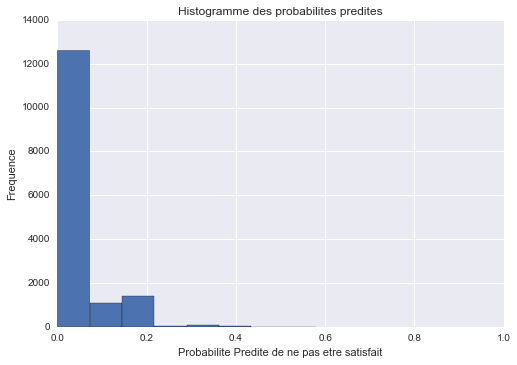

In [25]:
# On prédit pour les données de test
y_pred_class = SampleTree_GS.predict(XValid)

# on stocke la matrice de confusion et on récupère les TP, TN, FP, FN
confusion = metrics.confusion_matrix(YValid, y_pred_class)
tp = confusion[1, 1]
tn = confusion[0, 0]
fp = confusion[0, 1]
fn = confusion[1, 0]

print "Matrice de Confusion"
matrix = pd.DataFrame([confusion[0][0],confusion[1][0]])
matrix['1'] = [confusion[0][1],confusion[1][1]]
print matrix,"\n\n"

print "Taux de prédiction (accuracy): ",(tp + tn) / float(tp + tn + fp + fn)
print "Sensibilité : ",tp / float(tp + fn)
print"Precision", tp / float(tp + fp)
print"Spécificité ", tn / float(tn + fp),"\n\n"

# on stocke les degrés d'appartenance pour la classe 1
y_pred_prob = SampleTree_GS.predict_proba(XValid)[:, 1]

# histogramme des probabilités prédites
plt.hist(y_pred_prob, bins=8)
plt.xlim(0, 1)
plt.title('Histogramme des probabilites predites')
plt.xlabel('Probabilite Predite de ne pas etre satisfait' )
plt.ylabel('Frequence')

print "roc_auc_score = ", metrics.roc_auc_score(YValid, y_pred_prob)

Il faut **Diminuer le seuil** de prédiction du clients mécontents pour **augmenter la sensitivity** du classifieur !!!

<h4><span style="color: #c36b0f;">Selection des variables : Variance</span></h4>

In [ ]:
#Approche filtre
def variance_selection(X,n_features):
    
    variance = [np.var(X[i]) for i in X.columns]
    variance = sorted( zip(variance,X.columns) ,reverse=True)[:n_features]   
        
    return [x[1] for x in variance]

for n_features in [5,10,17,20,45]:
    print n_features
    varFeatures = variance_selection(X,n_features)
    #print 'Selected features : ', varFeatures
    gs = performance(X[varFeatures], Y)
    print gs.best_score_, gs.best_params_
    
    print '***************************\n'

In [26]:
#nombre d'attributs à utiliser
n_features=105

<br/><br/><br/><br/><h4><span style="color: #c36b0f;">Selection des variables : Correlation</span></h4>

In [360]:
#par filtre
def pearson_selection(X,y,n_features):
    
    corr = np.abs( X.corrwith(Y))
    corr = corr.sort_values(ascending=False)[:n_features]
    return corr.index.values

tr = te = nb = 0
gs=[]
pearsonFeatures=[]
for nb_features in [x+1 for x in xrange(n_features)]:
    
    pearsonFeatures.append(pearson_selection(X,Y,nb_features))
    #print 'Selected features : ', pearsonFeatures
    gs.append(performance(X[pearsonFeatures[-1]], Y))
    
for i in [x for x in xrange(len(gs))]:
    scoreTrain = gs[i].best_score_
    
    #scoreTest = validation(gs[i].best_estimator_, XValid[pearsonFeatures[i]], YValid)
    if scoreTrain > tr : #and scoreTest > te :
        tr = scoreTrain
        #te = scoreTest
        params = gs[i].best_params_
        nb=i
print "Complexité : ",nb+1
print "Score Train : ",tr, params
#print "Test : ",te
print "Liste des variables selectionées : \n",pearsonFeatures[nb]

Complexité :  67
Score Train :  0.817976317068 {'max_depth': 6, 'min_samples_leaf': 9}
Liste des variables selectionées : 
['ind_var30' 'num_meses_var5_ult3' 'num_var30' 'num_var42' 'ind_var5'
 'num_var5' 'var36' 'var15' 'num_var4' 'num_var35' 'ind_var8_0'
 'num_var8_0' 'num_var30_0' 'ind_var12_0' 'num_var13_0' 'num_var12_0'
 'ind_var39_0' 'saldo_var30' 'ind_var13_corto' 'num_meses_var13_corto_ult3'
 'num_var13_corto_0' 'imp_op_var41_efect_ult1' 'num_var41_0' 'ind_var5_0'
 'num_meses_var12_ult3' 'imp_op_var41_ult1' 'num_var39_0' 'saldo_var13'
 'ind_var24_0' 'num_var24_0' 'num_var42_0' 'num_var5_0' 'saldo_var13_corto'
 'saldo_medio_var13_corto_ult3' 'num_aport_var13_hace3'
 'num_meses_var8_ult3' 'imp_op_var41_efect_ult3' 'saldo_var42'
 'saldo_medio_var13_corto_hace2' 'num_op_var41_efect_ult1' 'num_var22_ult1'
 'num_op_var41_efect_ult3' 'ind_var25_cte' 'ind_var14_0' 'saldo_var12'
 'num_var14_0' 'ind_var43_recib_ult1' 'imp_aport_var13_hace3'
 'saldo_medio_var12_ult1' 'num_var26_0' 'saldo_

<h3>Selection des variables : Correlation</h3>

<b>Complexité</b> :  67 <br/>
<b>Train</b> :  0.817976317068 {'max_depth': 6, 'min_samples_leaf': 9}<br/>
<b>Liste des variables selectionées : </b><br/>
['ind_var30' 'num_meses_var5_ult3' 'num_var30' 'num_var42' 'ind_var5'
 'num_var5' 'var36' 'var15' 'num_var4' 'num_var35' 'ind_var8_0'
 'num_var8_0' 'num_var30_0' 'ind_var12_0' 'num_var13_0' 'num_var12_0'
 'ind_var39_0' 'saldo_var30' 'ind_var13_corto' 'num_meses_var13_corto_ult3'
 'num_var13_corto_0' 'imp_op_var41_efect_ult1' 'num_var41_0' 'ind_var5_0'
 'num_meses_var12_ult3' 'imp_op_var41_ult1' 'num_var39_0' 'saldo_var13'
 'ind_var24_0' 'num_var24_0' 'num_var42_0' 'num_var5_0' 'saldo_var13_corto'
 'saldo_medio_var13_corto_ult3' 'num_aport_var13_hace3'
 'num_meses_var8_ult3' 'imp_op_var41_efect_ult3' 'saldo_var42'
 'saldo_medio_var13_corto_hace2' 'num_op_var41_efect_ult1' 'num_var22_ult1'
 'num_op_var41_efect_ult3' 'ind_var25_cte' 'ind_var14_0' 'saldo_var12'
 'num_var14_0' 'ind_var43_recib_ult1' 'imp_aport_var13_hace3'
 'saldo_medio_var12_ult1' 'num_var26_0' 'saldo_medio_var12_ult3' 'var38'
 'saldo_medio_var5_hace2' 'saldo_medio_var5_ult3' 'saldo_medio_var12_hace2'
 'num_var43_recib_ult1' 'saldo_medio_var5_ult1'
 'saldo_medio_var13_corto_hace3' 'saldo_medio_var5_hace3'
 'num_meses_var39_vig_ult3' 'saldo_var13_largo' 'saldo_var5'
 'num_med_var22_ult3' 'num_op_var41_ult1' 'imp_trans_var37_ult1'
 'num_op_var41_ult3' 'imp_op_var39_comer_ult1']


<br/><br/><br/><br/><h4><span style="color: #c36b0f;">Selection des variables : Random Forest</span></h4>

In [33]:
#Approche integree
def random_forest_selection(X,Y,n_features):
    
    params = {'max_depth':[6],
              'min_samples_leaf' : [4]}
    
    clf = RandomForestClassifier(random_state=1, n_jobs=3)
    gs = GridSearchCV(clf, params)
    gs.fit(X,Y)
    bestClf = gs.best_estimator_
    rf = bestClf.feature_importances_
    
    rf=zip(rf,X.columns)
    rf=sorted(rf,reverse=True)[:n_features]
 
    return [x[1] for x in rf]

%time rfFeatures = random_forest_selection(X,Y,20)


##Random_Forest_GS=[]

#%time for nb in xrange(len(rfFeatures)):
   # Random_Forest_GS.append(performance(X[rfFeatures[:nb+1]], Y))


CPU times: user 2.68 s, sys: 380 ms, total: 3.06 s
Wall time: 2.64 s



pour   :  1
scoreTrain =  0.709427190377      Paramètres =  {'max_depth': 5, 'min_samples_leaf': 1}

pour   :  2
scoreTrain =  0.78184723184      Paramètres =  {'max_depth': 4, 'min_samples_leaf': 1}

pour   :  3
scoreTrain =  0.808831956489      Paramètres =  {'max_depth': 5, 'min_samples_leaf': 9}

pour   :  4
scoreTrain =  0.812980388507      Paramètres =  {'max_depth': 6, 'min_samples_leaf': 1}

pour   :  5
scoreTrain =  0.814360412165      Paramètres =  {'max_depth': 5, 'min_samples_leaf': 9}

pour   :  6
scoreTrain =  0.814655077484      Paramètres =  {'max_depth': 5, 'min_samples_leaf': 9}

pour   :  7
scoreTrain =  0.814978703594      Paramètres =  {'max_depth': 6, 'min_samples_leaf': 4}

pour   :  8
scoreTrain =  0.814603552267      Paramètres =  {'max_depth': 5, 'min_samples_leaf': 9}

pour   :  9
scoreTrain =  0.813747575685      Paramètres =  {'max_depth': 5, 'min_samples_leaf': 3}

pour   :  10
scoreTrain =  0.813747575685      Paramètres =  {'max_depth': 5, 'min_samples_

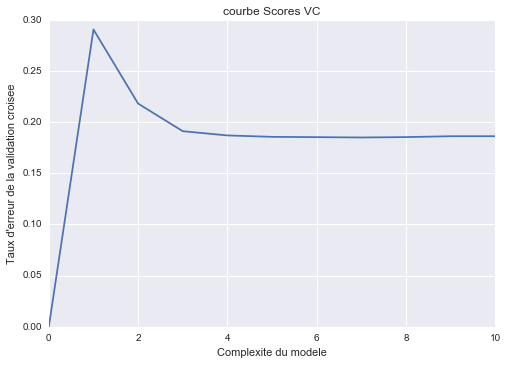

In [29]:
tr = n = nb =0
listeScoreVC=[0]

for i in xrange(len(Random_Forest_GS)): 
    n = n + 1
    scoreTrain = Random_Forest_GS[i].best_score_
    params = Random_Forest_GS[i].best_params_
    #Selection manuelle 
    print '\npour   : ', n
    print "scoreTrain = ",scoreTrain,"     Paramètres = ",params
    
    listeScoreVC.append(1.0 - scoreTrain)
    
    #Selection automatique 
    if scoreTrain > tr :
        tr = scoreTrain
        param = Random_Forest_GS[i].best_params_
        nb=n
    
        
plt.plot([x for x in xrange(len(listeScoreVC))], listeScoreVC)
plt.title('courbe Scores VC')
plt.xlabel('Complexite du modele')
plt.ylabel('Taux d\'erreur de la validation croisee')
plt.grid(True)
        
print "\n\n================================================"        
print 'pour   : ', nb
print 'Selected features : ', rfFeatures[:nb]
print "scoreTrain = ",tr,"     Paramètres = ",param
print "================================================"

In [39]:
rfFeatures

['var38',
 'ind_var30',
 'var15',
 'saldo_medio_var5_ult1',
 'saldo_var30',
 'saldo_medio_var5_ult3',
 'num_meses_var5_ult3',
 'num_var30',
 'num_var35',
 'imp_op_var41_efect_ult1',
 'var36',
 'num_var22_ult3',
 'num_var22_ult1',
 'imp_op_var41_efect_ult3',
 'num_var45_hace3',
 'saldo_var5',
 'num_var22_hace2',
 'imp_op_var41_ult1',
 'num_med_var45_ult3',
 'num_var4']

<h4><span style="color: #c36b0f;">Selection des variables : LASSO</span></h4>

In [47]:
def lasso_selection(X,Y,n_features):
    
    cols = X.columns
    X=StandardScaler().fit_transform(X)
  
    params = {'alpha':[0.0001, 0.001, 0.01, 0.1, 1, 2, 5]}
    
    clf = Lasso(random_state=1)
    gs = GridSearchCV(clf, params)
    gs.fit(X,Y)
    ls = gs.best_estimator_.coef_
    
    ls=zip(ls,cols)
    ls=sorted(ls,reverse=True)[:n_features]
 
    return [x[1] for x in ls]

lassoFeatures = lasso_selection(X,Y,60)
print 'Selected features : ', lassoFeatures
gs = performance(X[lassoFeatures], Y)
print gs.best_score_, gs.best_params_


Selected features :  ['var15', 'num_var5', 'ind_var8_0', 'ind_var30_0', 'num_var22_ult1', 'num_op_var41_efect_ult3', 'num_meses_var12_ult3', 'num_meses_var39_vig_ult3', 'imp_op_var39_comer_ult1', 'var36', 'imp_op_var41_ult1', 'imp_op_var41_efect_ult1', 'num_ent_var16_ult1', 'ind_var1_0', 'num_var45_ult1', 'num_var22_hace2', 'num_med_var22_ult3', 'imp_var43_emit_ult1', 'num_op_var41_hace2', 'saldo_medio_var12_hace2', 'ind_var10_ult1', 'num_var45_hace3', 'num_var42_0', 'num_var14_0', 'delta_imp_aport_var13_1y3', 'num_var13_corto_0', 'saldo_var37', 'ind_var25_cte', 'saldo_medio_var13_corto_hace2', 'num_var45_ult3', 'saldo_medio_var5_hace3', 'saldo_medio_var8_hace2', 'num_op_var39_comer_ult3', 'saldo_var42', 'saldo_var13_corto', 'saldo_var12', 'saldo_medio_var8_ult3', 'saldo_medio_var13_corto_ult3', 'saldo_medio_var12_ult3', 'saldo_medio_var12_ult1', 'num_var8_0', 'num_var5_0', 'num_var45_hace2', 'num_var43_emit_ult1', 'num_var41_0', 'num_var37_0', 'num_var35', 'num_var30_0', 'num_var30', 

<h4><span style="color: #c36b0f;">Selection des variables : Forward Selection</span></h4>

In [78]:
#Wrapper
def forward_selection(X,Y,n_features):
    
    fsFeatures = []
    startFeatures = list(X.columns.values)
    listOfScores=[]; listValidationScores=[]
    
    while( len(startFeatures) > 0 ) : # len(fsFeatures)<n_features
        bestScore = 0; bestFeature = None; bestClf=None
        for feature in startFeatures:    
            sousEnsemble = fsFeatures+[feature]
            gs = performance(X[sousEnsemble],Y)
            if gs.best_score_>bestScore:
                bestScore = gs.best_score_
                bestFeature = feature
                bestClf = gs.best_estimator_
                
        fsFeatures.append(bestFeature)
        listOfScores.append(bestScore)
        listValidationScores.append( validation(bestClf, XValid[fsFeatures], YValid) )
        startFeatures = list( set(startFeatures) - set(fsFeatures) )
        
    return fsFeatures,listOfScores, listValidationScores

In [53]:
Features,TrainScores,ValidationScores = forward_selection(X[pearsonFeatures],Y,n_features)

In [ ]:
plt.figure(figsize=(20,10))
plt.plot(TrainScores,'b')
plt.plot(ValidationScores,'r')
_=plt.xticks(range(len(Features)), Features)

<h3><span style="color: #3366ff;">Modèle : SVM</span></h3>

In [ ]:
from sklearn.svm import LinearSVC, SVC

Cs = [0.001, 0.01, 0.1, 1, 10]
gammas = [0.001, 0.01, 0.1, 1, 10]
param_grid = {'C': Cs, 'gamma' : gammas}

kf = StratifiedKFold(Y, n_folds=3, random_state=1)   
grid_search = GridSearchCV(SVC(), param_grid, cv=kf)
grid_search.fit(X, Y)

In [ ]:
print("The best parameters are %s with a score of %0.2f"
      % (grid_search.best_params_, grid_search.best_score_))

In [40]:
print "Score de validation", validation(grid_search.best_estimator_, XValid, YValid)

<h3><span style="color: #3366ff;">Modèle : Boosting + SVM</span></h3>

In [41]:
from sklearn.ensemble import AdaBoostClassifier
nb_estimators = [5,10]
line_rate = [1.0, 0.8, 0.6, 0.4]
param_grid = {'n_estimators': nb_estimators, 'learning_rate' : [1.0]}

clf = AdaBoostClassifier(SVC(probability=True,kernel='linear'), algorithm='SAMME')

BoostSvm_SG = GridSearchCV(clf, param_grid)

In [ ]:
BoostSvm_SG.fit(X, Y)

In [ ]:
print("The best parameters are %s with a score of %0.2f"
      % (BoostSvm_SG.best_params_, BoostSvm_SG.best_score_))

In [ ]:
print "Score de validation", validation(BoostSvm_SG.best_estimator_, XValid, YValid)

<h3><span style="color: #3366ff;">Modèle : VotingClassifier </span></h3>

In [ ]:
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression

kf = StratifiedKFold(Y, n_folds=3, random_state=1)   

clf1 = LogisticRegression(random_state=1, n_jobs=3)
clf2 = RandomForestClassifier(random_state=1, max_depth=6, min_samples_leaf=7)

eclf = VotingClassifier(estimators=[('lr', clf1), ('rf', clf2)], voting='soft')

for clf, label in zip([clf1, clf2, eclf], ['Logistic Regression', 'Random Forest', 'Ensemble']):
        scores = cross_validation.cross_val_score(clf, X, Y, cv=kf, scoring='metric')
        print("Accuracy: %0.2f (+/- %0.2f) [%s]" % (scores.mean(), scores.std(), label))

In [ ]:
# Training classifiers
kf = StratifiedKFold(Y, n_folds=3, random_state=1) 

#clf1 = DecisionTreeClassifier(random_state=1, max_depth=6, min_samples_leaf=4)
clf1 = Random_Forest_GS[6]
clf2 = KNeighborsClassifier(n_neighbors=7)
clf3 = SVC(kernel='rbf', probability=True)
clf4 = LogisticRegression(random_state=1, n_jobs=3)

eclf = VotingClassifier(estimators=[('dt', clf1), ('knn', clf2), ('svc', clf3), ('lr', clf4)], voting='hard')

for clf, label in zip([clf1, clf2, clf3, clf4, eclf], ['Descion tree', 'K neighbors', 'svm', 'Logistic Regression', 'Ensemble']):
        scores = cross_validation.cross_val_score(clf, X, Y, cv=kf, scoring='metric')
        print("Accuracy: %0.2f (+/- %0.2f) [%s]" % (scores.mean(), scores.std(), label))

#clf1 = clf1.fit(X,y)
clf2 = clf2.fit(X,y)
clf3 = clf3.fit(X,y)
clf4 = clf4.fit(X,y)
eclf = eclf.fit(X,y)

<br/><br/><br/><br/><br/>

# END

<br/><br/><br/><br/><br/><br/><br/>